# Talbot Effect for Dispersive PDEs

*an Illinois Geometry Lab project*

Undergraduate researchers: Zhouzhen Cai, Wei-Chen Huang, Hui Lyu, and Spencer Rooke <br />
Graduate Leader: George Shakan <br />
Faculty Mentors: Prof. Burak Erdogan and Prof. Nikolaos Tzirakis

## Introduction

The solution profiles of dispersive partial differential equations depends heavily on the algebraic properties of time. At rational times with respect to the period, the solution is a piece-wise step function. However, at irrational times with respect to the period, the solution is a continuous, but nowhere differentiable fractal curve. This phenomenon is known as the “Talbot Effect”, which is when the solutions to dispersive PDE exhibit two vastly different behaviours, depending on what time they are calculated.

Since the solution curves at irrational times are very fractal-like, they are quite chaotic and can oscillate very quickly. We can look at the box-dimension of these curves in order to get an idea of how chaotic each solution is.

## Methods
### The Split Step Method
The general equation we need to solve is:

$$
  iu_t + P(\frac{\partial}{\partial x})u + \vert u \vert^pu = 0
$$

In particular, for 
$ P(\frac{\partial}{\partial x}) = (\frac{\partial}{\partial x})^2 $ and $ p=2 $, we can derive the solutions corresponding to the linear and nonlinear parts of Schrodinger equation separately by:

$$
        Linear:= \begin{cases}
                    iu_t+u_{xx}=0\\
                    u(x,0)=g(x)\\
                \end{cases}
$$

where the solution to the linear part is

$$
    u(x,t)=\sum\limits_{k=-\infty}^{\infty}e^{-itk^2}\hat{g}(k)e^{ikx}
$$

$$
        Nonlinear:= \begin{cases}
	                iu_t+\vert u \vert^2u=0\\
	                u(x,0)=g(x)
	            \end{cases}
$$

where the solution to the nonlinear part is

$$
  u(x,t)=e^{it \vert g(x)\vert ^2}g(x)  
$$

Notice that the initial function (condition) we are using here is

$$
    u(x,0)=g(x)=\begin{cases}
	    1& :0 \leq x \leq \pi\\
	    -1& :\pi < x \leq 2\pi
	    \end{cases}
$$

To use the **Split Step Method**, we can apply the linear and nonlinear solutions at small time steps and compose them to obtain the total solution:

$$ u(x, n \Delta t) = F^{-1}[e^{-iw(k)\Delta t}F(e^{i\Delta t \vert u(x,\Delta t(n-1)) \vert^{p=2}}u(x,\Delta t(n-1))]
$$

$$ 
\text{for}\ n = 0,1,2,...,\ \text{given}\ u(x,0)=u_0
$$

where $F$ is the Fourier transformation, $w$ is the dispersion relation defined by the polynomial $P$, and we sum over $n$. The **Split Step Method** works by applying the nonlinear and linear transformations for small times $t$, and iterating the initial conditions. For example, if we evaluate $u$ at time $\Delta t$, we can then set that as our new $u_0(x,0)$, and so $u(x,2 \Delta t) = u_0(x,\Delta t)$. By repeating this, we can approximate solutions $u(x,n \Delta t)$. We found that the most efficient way to evaluate $u(x,\Delta t)$ was to apply the nonlinear part in the time domain, and then apply the linear part in the frequency domain. This allows us to avoid calculating Fourier coefficients repeatedly for each new set of initial conditions, which saves us a great deal of time. This method can be shown to converge.



#### Implementation

The `Solver` class below implements the Split Step Method to solve dispersive nonlinear PDEs, given a set of input data packed into the class `Data`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from statistics import mean

pi = math.pi
j = 1j   # imaginary number iclass Data:

In [2]:
class Data:
    """ Class to store input data for the equation being solved
    
    Args:
        t: time resolution (time step); default to 0.00001 * pi
        n: number of sample points in the domain; default to 1024 * 8
        e: evaluation time (time step stop condition); default to 0.1 * pi
        p: power that corresponds to u|u|^p; default to 2
    """
    def __init__(self, t=0.00001 * pi, n=1024 * 8, e=0.1 * pi, p=2):
        self.time_resolution = t
        self.samples = n
        self.evaluation_time = e
        self.power = p
            

In [3]:
class Solver:
    """ Solves the dispersive nonlinear partial differential equation with a set of input data
        
        Given a set of input data, the Solver class solves the dispersive nonlinear PDE, stores,
        and outputs the solution graph.
        
    Args:
        input_data: input information of type 'Data'
        
    Attributes:
        eqn: 1 == Schrodinger, 2 == KdV, 3 == Airy
        domain: a numpy line space (x-axis) of the points in the time domain [0, 2*pi]
        dx: a float of the interval of the domain
        k: a float array of the Discrete Fourier Transform sample frequencies
            (dx under division sign is due to an extra term in the index. DO NOT CHANGE)
        hf: a float of half the number of samples
        real_array: a numpy array of the real part of the solution points
        imag_array: a numpy array of the imaginary part of the solution points
        norm_array: a numpy array of the norm of the solution points
        curr_u: use for animation
    """
    def __init__(self, input_data, eqn):
        self.time_resolution = input_data.time_resolution
        self.samples = input_data.samples
        self.evaluation_time = input_data.evaluation_time
        self.power = input_data.power

        self.eqn = eqn
        self.domain = np.linspace(0, 2 * pi, self.samples)
        self.dx = self.domain[1] - self.domain[0]
        self.k = np.fft.fftfreq(self.samples, d=self.dx / (2 * pi + self.dx))
        self.hf = int(self.samples / 2)
        self.real_array = np.zeros(self.samples)
        self.imag_array = np.zeros(self.samples)
        self.norm_array = np.zeros(self.samples)
        self.curr_u = None

    def w(self, point_array):
        """ Dispersion relation w(n).
        
            For the nonlinear Schrodinger equation, it is -n^2.
            For Korteweg-deVries (KdV), it is Can be set to any function.
            For Airy equation, it is -n^3
        
        Args:
            point_array: a float array of points
            
        Returns:
            a float array of points transformed by the dispersion relation function
        """
        if self.eqn == 1:
            return -(abs(point_array ** 2))
        elif self.eqn == 2:
            return -(abs(point_array**3)) + point_array
        elif self.eqn == 3:
            return -(abs(point_array ** 3))
        else:
            raise ValueError("Invalid value for equation")

    def f_not(self, point):
        """ Helper function of initial conditions.
        
        Can be set to any function.
        
        Args:
            point: a float of point in the domain [0, 2*pi]
            
        Returns:
            value mapped by the initial condition function
        """
        if 0 <= point <= pi:
            return 1
        if pi < point <= 2 * pi:
            return -1
        else:
            return 0

    def f_init(self, point_array):
        """ Initial function.
        
            Apply initial condition function f_not on an array of points to get the initial function.
        
        Args:
            point_array: a float array of points in the domain [0, 2*pi]
        
        Returns:
            work_array: a float numpy array of points mapped by the initial condition function
        """
        work_array = np.zeros(self.samples)
        for i in range(0, self.samples):
            work_array[i] = self.f_not(point_array[i])
        return work_array

    def nonlinear_flow(self, func_array):
        """ The function of nonlinear flow.
            
            Returns the nonlinear flow e^(i * dt * |u(x, dt*(n-1))|^p)
        
        Args:
            func_array: a float array of points in the domain [0, 2*pi]
        
        Returns:
           work_array: a float array of points mapped by the initial condition function
        """
        dt = self.time_resolution
        arg = j * dt * (abs(func_array) ** self.power)
        return np.exp(arg)

    def total_u(self, t_final):
        """ Calculates the final solution via the Split Step Method.
        
            Returns the total solution u(x, n * dt).
        
        Args:
            t_final: stop condition for the time step
        
        Returns:
           current_u: a numpy array of solution points after iterations of split step method.
        """
        dt = self.time_resolution
        current_time = 0
        current_u = self.f_init(self.domain)
        while current_time < t_final:
            step_1 = self.nonlinear_flow(current_u) * current_u
            step_2 = np.exp(-j * self.w(self.k) * dt) * np.fft.fft(step_1)
            current_u = np.fft.ifft(step_2)
            current_time += dt
        return current_u

    def solution(self):
        """ Handles the final solution.
        
            Calls total_u to calculate the solution. Stores the final solution and calculates
            the norm of the solution. Returns the real and imaginary parts of the solution,
            as well as the norm of the solution.
        
        Returns:
           self.real_array, self.imag_array, self.norm_array: numpy array of the corresponding solutions
        """
        time = self.evaluation_time
        array = self.total_u(time)
        self.real_array = array.real
        self.imag_array = array.imag
        self.norm_array = np.sqrt(self.imag_array ** 2 + self.real_array ** 2)
        return self.real_array, self.imag_array, self.norm_array

    def print_graph(self, norm_only=True):
        """ Prints the solution graphs.
        
        Prints the real, imaginary parts of the solution, as well as the norm of the solution.
        """
        if norm_only:
            f, axarr = plt.subplots(1, sharex=True)
            axarr.plot(self.domain, self.norm_array)
            axarr.set_title('Norm')
            f.set_size_inches(33, 8)
        else:
            f, axarr = plt.subplots(3, sharex=True)
            axarr[0].plot(self.domain, self.real_array)
            axarr[0].set_title('Real Part')
            axarr[1].plot(self.domain, self.imag_array)
            axarr[1].set_title('Imaginary Part')
            axarr[2].plot(self.domain, self.norm_array)
            axarr[2].set_title('Norm')
            f.subplots_adjust(hspace=.5)
            f.set_size_inches(33, 24)
        return f

    def calc_box_dim(self, plot=False):
        b = BoxDimension(self.norm_array, self.dx, self.samples)
        b.box_dim(plot)
        return b.box_dim_val
        

### Box Dimension
The box dimension of a fractal curve $u$ is given by the following:

$$
Dim_{box}(u)= \lim_{\varepsilon\to 0} \frac{log(N_\varepsilon)}{log(1/\varepsilon)}
$$

where $N_\varepsilon$ is the number of boxes with edge length epsilon required to cover the fractal.

As we were calculating this numerically, we could not take this limit exactly. Instead, we found $N_\varepsilon$ for varying values of epsilon and approximated the box dimension by taking the slope of $\frac{log(N_\varepsilon)}{log(1/\varepsilon)}$ for varying values of $\varepsilon$. By splitting the domain into chunks of width epsilon, subtracting the min of $u$ from the max of $u$ on the interval, and summing over all such intervals on our domain, we can find $N_\varepsilon$:

$$
N_\varepsilon = \sum\limits_{i=0}^{N}\frac{\lceil \max(u) \rceil - \lfloor \min(u) \rfloor }{\varepsilon} \; ,
          \; \; \; \; n\varepsilon < x < (n+1)\varepsilon
$$

#### Implementation

The `BoxDimension` class implements the above equation to calculate the box dimension value of our solution curve.

In [4]:
class BoxDimension:
    """ Calculates the box dimension of the solution graph.
        
        Given a set of solution points, the BoxDimension class calculates the box dimension and outputs the solution.
        
        Args:
            sample_array: the solution array of type numpy array
        
        Attributes:
            sample_array: the solution array of type numpy array
            dy: a float of the interval of the domain; equivalent to dx
            n_min: default to 10
            n_max: default to 45
            samples: number of sample points in the domain
    """

    def __init__(self, sample_array, dy, samples):
        self.sample_array = sample_array
        self.dy = dy
        self.n_min = 10
        self.n_max = 45
        self.samples = samples
        self.box_dim_val = 0

    def box_dim(self, plot):
        n_array_1 = np.zeros(self.n_max - self.n_min)  # x-axis
        n_array_2 = np.zeros(self.n_max - self.n_min)  # y-axis

        n = self.n_min
        while n < self.n_max:
            i = 0
            epsilon = n * self.dy
            n_epsilon = 0
            while i < self.samples:
                array_chunk = self.sample_array[i:i + n]
                high = np.amax(array_chunk)
                low = np.amin(array_chunk)
                d_high = math.ceil(high / epsilon)  # Number of boxes to reach top of array_chunk
                d_low = math.floor(low / epsilon)   # ^^
                n_epsilon += d_high - d_low
                i += n
            n_array_1[n - self.n_min] = np.log(1 / epsilon)
            n_array_2[n - self.n_min] = np.log(n_epsilon)
            n += 1
        m = (mean(n_array_1) * mean(n_array_2) - mean(n_array_1 * n_array_2))
        m = m / (mean(n_array_1) * mean(n_array_1) - mean(n_array_1 * n_array_1))
        # slope of line of best fit
        print("boxDimension = " + str(m))
        self.box_dim_val = m
        
        if plot:
            a = mean(n_array_2) - m * mean(n_array_1)
            y = n_array_1 * m + a
            fig = plt.figure()
            ax = fig.gca()
            fig.set_size_inches(11, 8)
            ax.set_xlabel("ln(1/epsilon)")
            ax.set_ylabel("ln(N_epsilon)")
            plt.plot(n_array_1, n_array_2, 'o')
            plt.plot(n_array_1, y, color='red')


## Results

In [5]:
def get_result(t=0.00001 * pi, n=1024 * 8, e=0.3, p=2, eqn=1):
    result = Solver(Data(t, n, e, p), eqn)
    sol = result.solution()
    result.print_graph()
    box_dim = result.calc_box_dim()

### Nonlinear Schrodinger

The followings are graphs of the solution to the periodic nonlinear Schrodinger with fixed $p = 2$ and fixed time resolution $t = 0.00001π$, at evaluation times $e = 0.3, e = 0.31, e = 0.314,$ and $e = 0.1π$ respectively:

boxDimension = 1.313050921113405


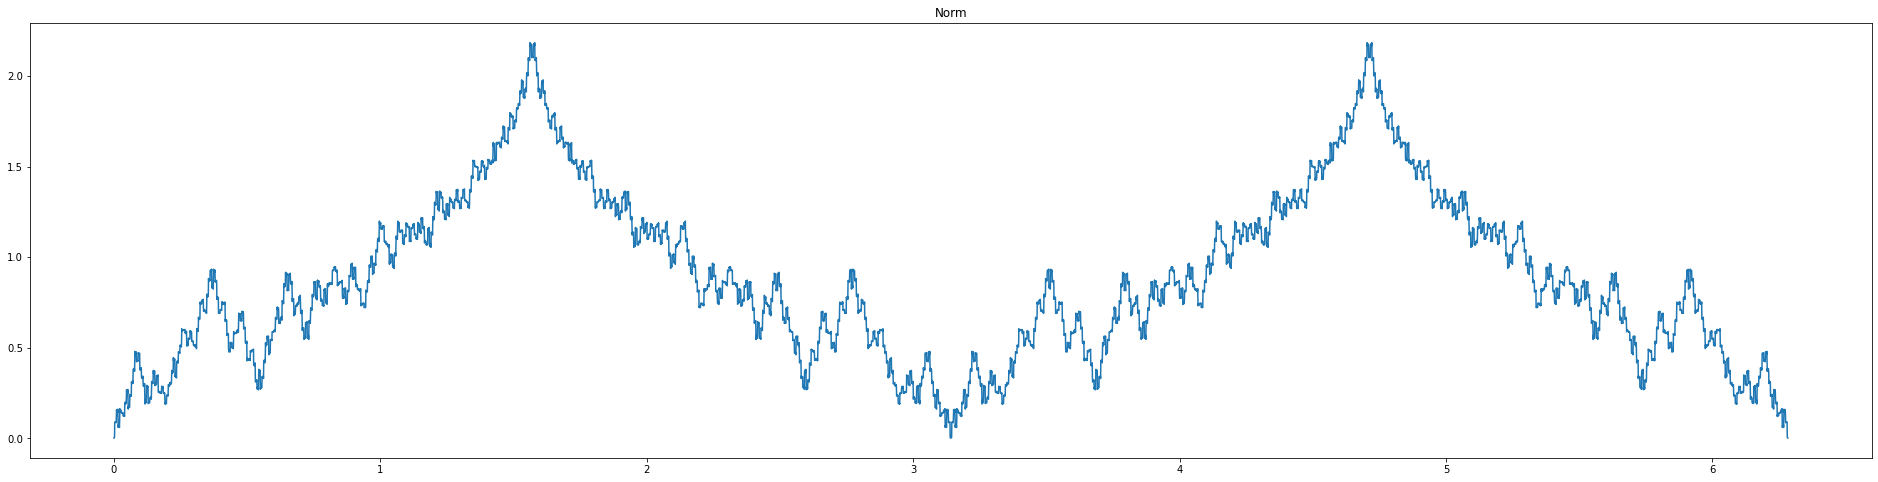

In [6]:
get_result(e=0.3, p=2, eqn=1)

boxDimension = 1.42801415606029


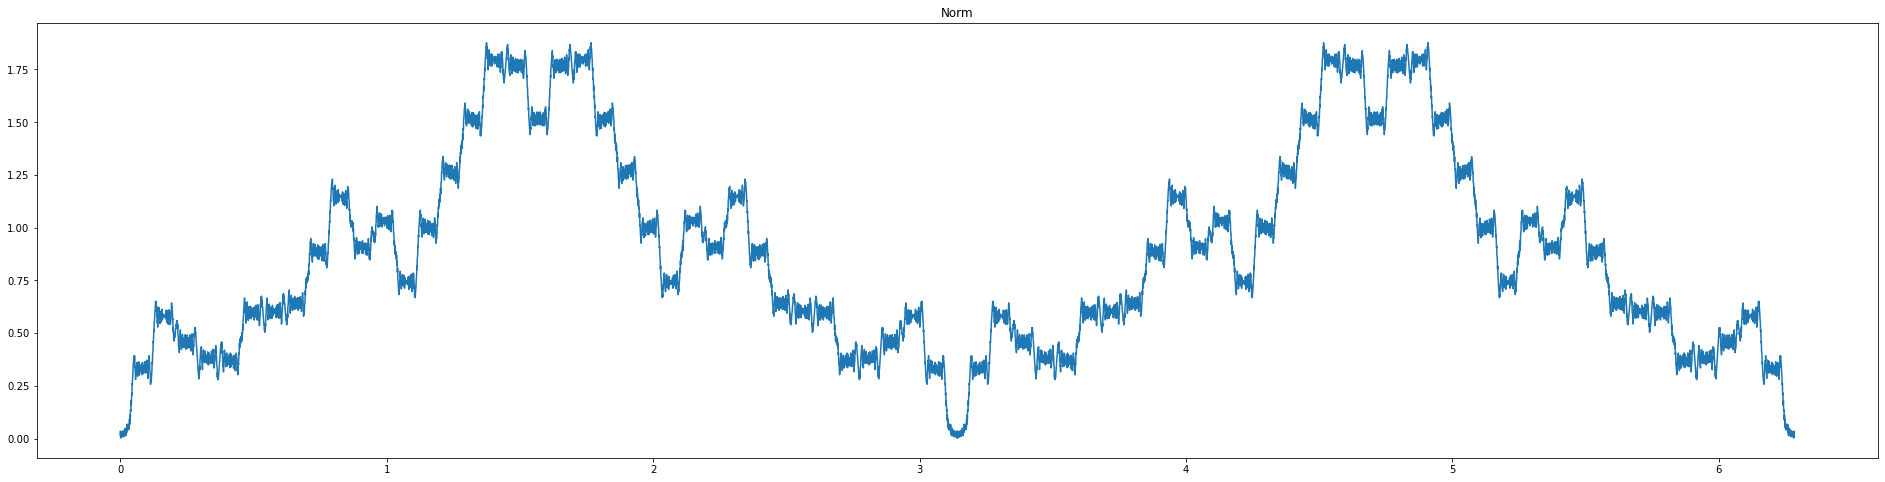

In [7]:
get_result(e=0.31, p=2, eqn=1)

boxDimension = 1.4867079639375


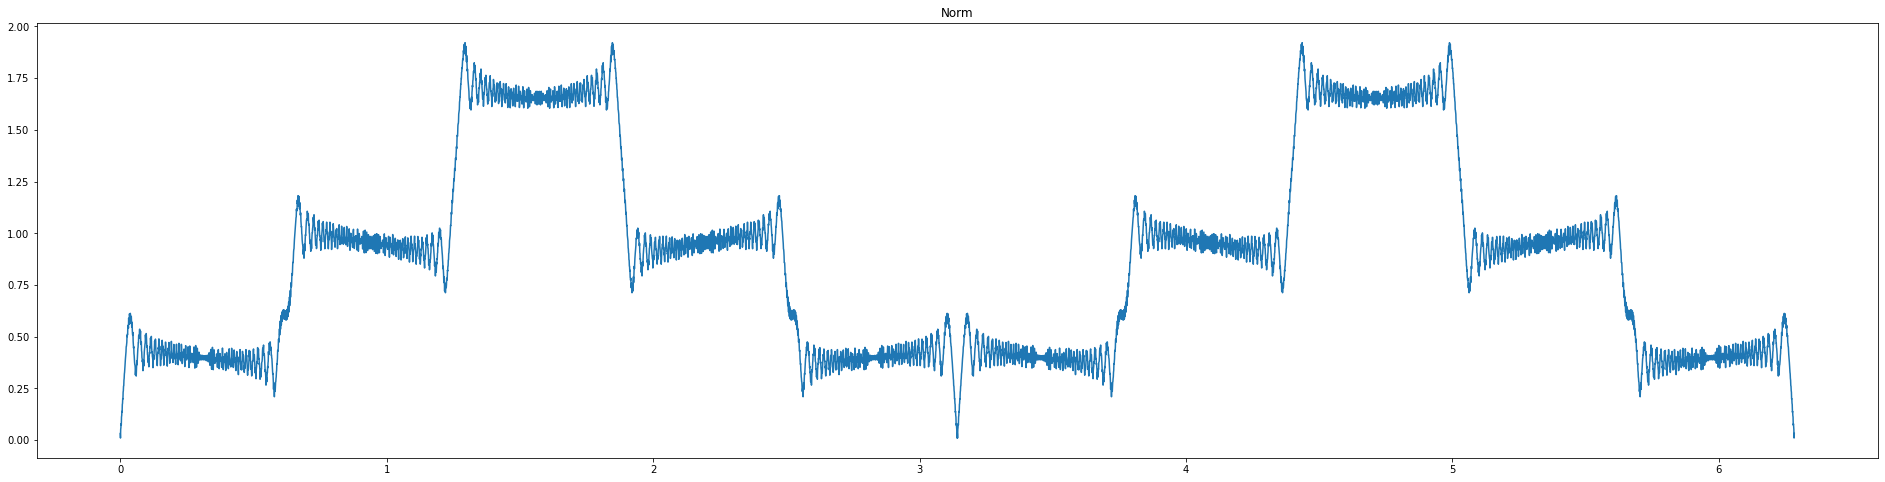

In [8]:
get_result(e=0.314, p=2, eqn=1)

boxDimension = 1.0405559292315782


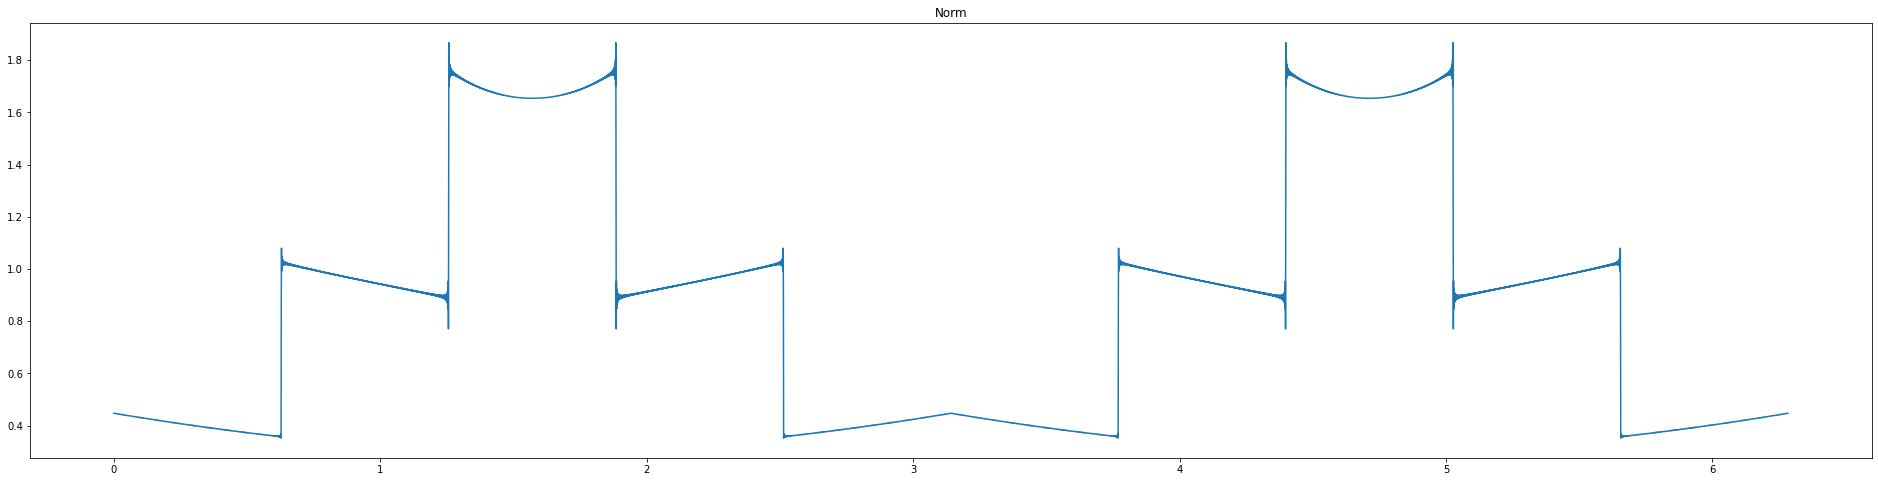

In [9]:
get_result(e=0.1 * pi, p=2, eqn=1)

The time period $t = 0.3, t = 0.31$, and $t = 0.314$ will be irrational multiples of the space interval $2π$. The curves are chaotic and oscillates quickly, and the functions are continuous but nowhere differentiable fractal-like functions. For $t = 0.1π$, which is a rational multiple of the space interval, the solution is piece-wise step function, but discontinuous. Also, this behavior does not happen suddenly. Instead, as the accuracy of the decimal increased, which makes the $t$ value closer to the actual $0.1π$, the function behaves more similar to the step function.

The followings are graphs of the norm of the solution to the periodic nonlinear Schrodinger with fixed $e = 0.1π$ and $p = 0, p = 2, p = 4,$ and $p = 6$ respectively:

boxDimension = 1.0610484934285782


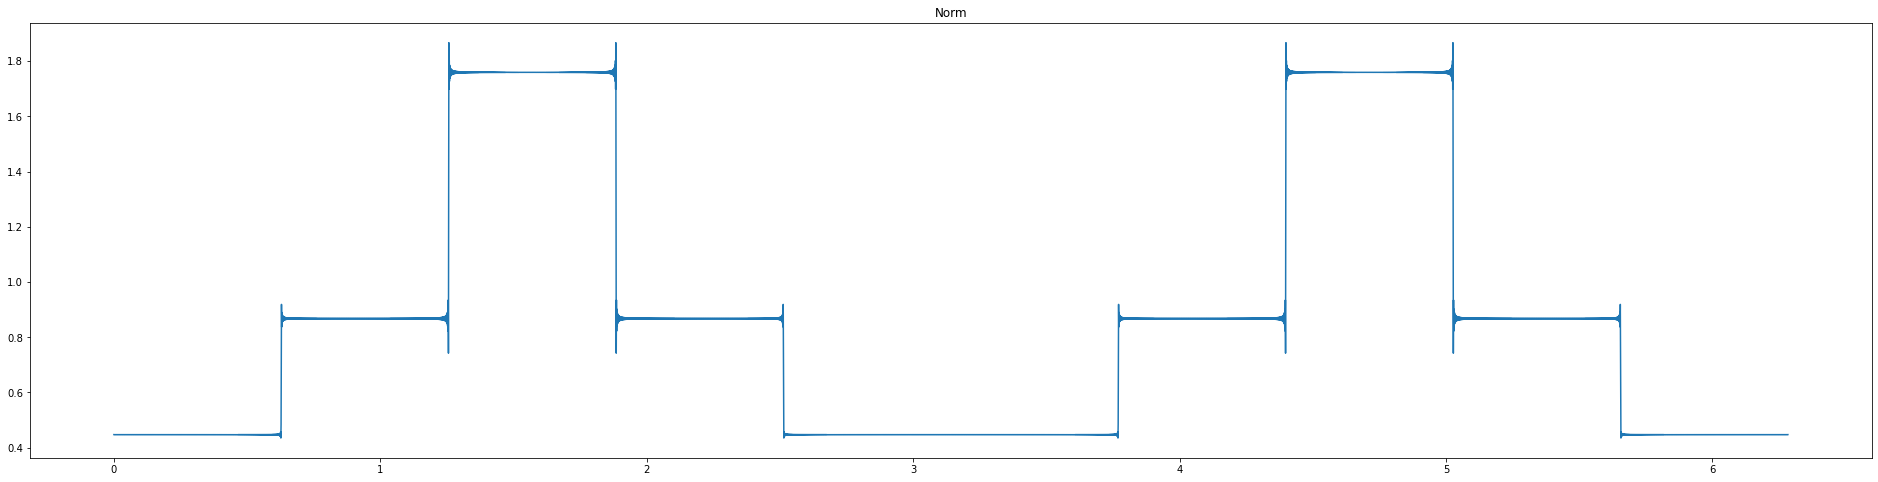

In [10]:
get_result(e=0.1 * pi, p=0, eqn=1)

boxDimension = 1.0405559292315782


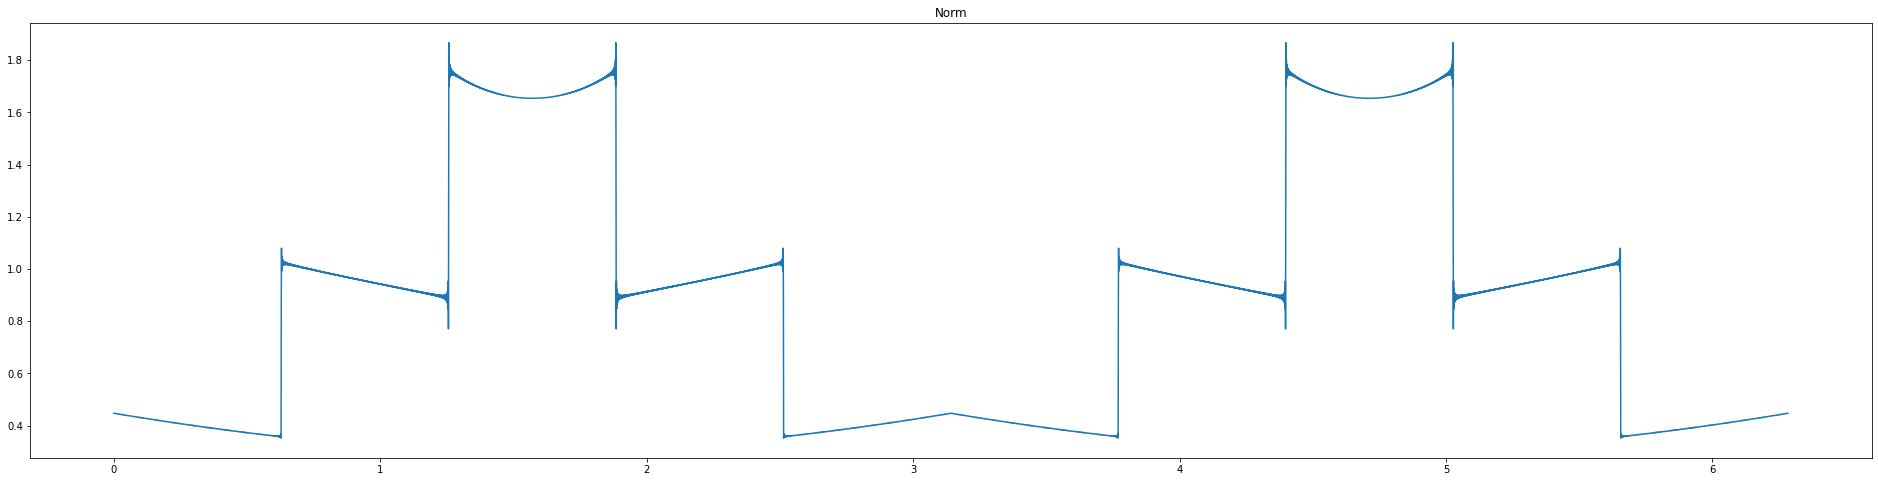

In [11]:
get_result(e=0.1 * pi, p=2, eqn=1)

boxDimension = 1.0336638394897568


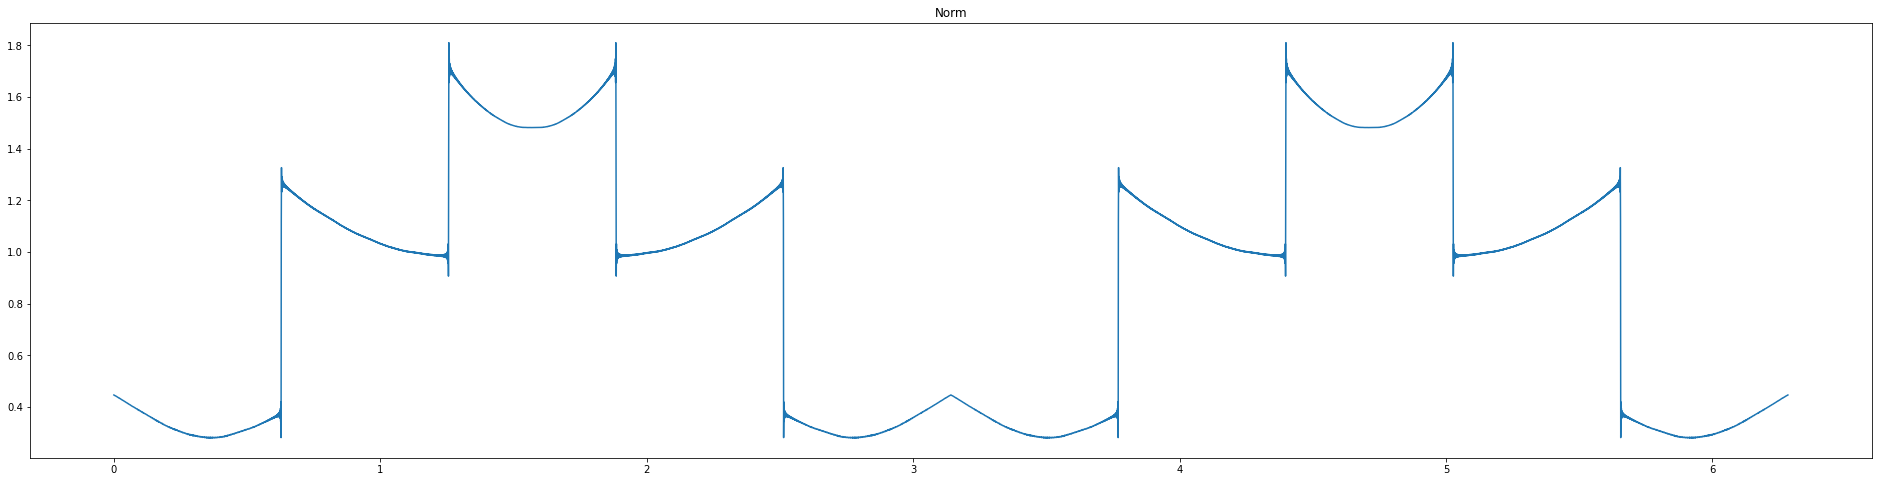

In [12]:
get_result(e=0.1 * pi, p=4, eqn=1)

boxDimension = 1.0198542740224705


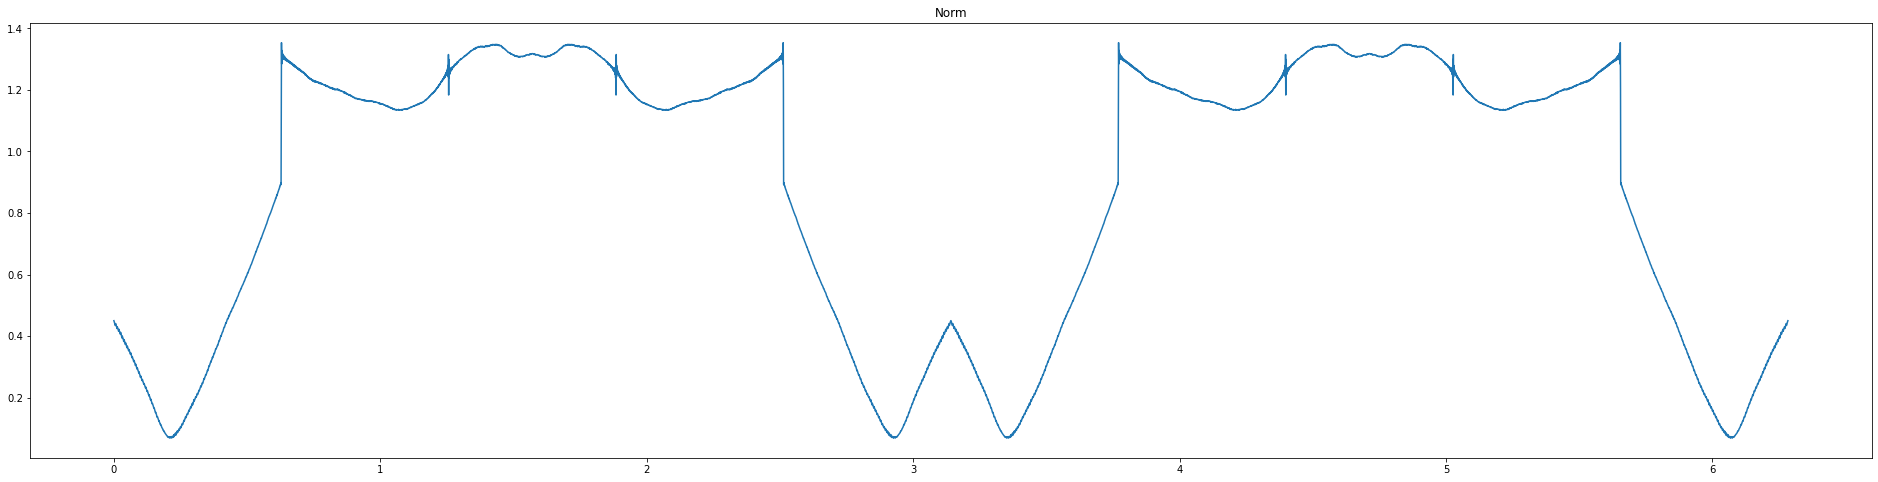

In [13]:
get_result(e=0.1 * pi, p=6, eqn=1)

When $p = 2, 4,$ and $6$, the solutions are shifted vertically and they are no longer piece-wise constant as what the function presents when $p = 0$, but they do preserve the nature of step function. The curly shape exhibits the effect of non-linearity.


Here is the example graph of box dimension when $p = 2, e = 0.1$. The slope of the best fitting line equals to the box dimension which is in the range of $(1, 2)$. A steeper slope with a high value means that the solution curve is more ”fractally”, so it gains in complexity more quickly as the magnification decreases. The box dimension of the solution curve in this condition is about $1.338$.

boxDimension = 1.3382170342607258


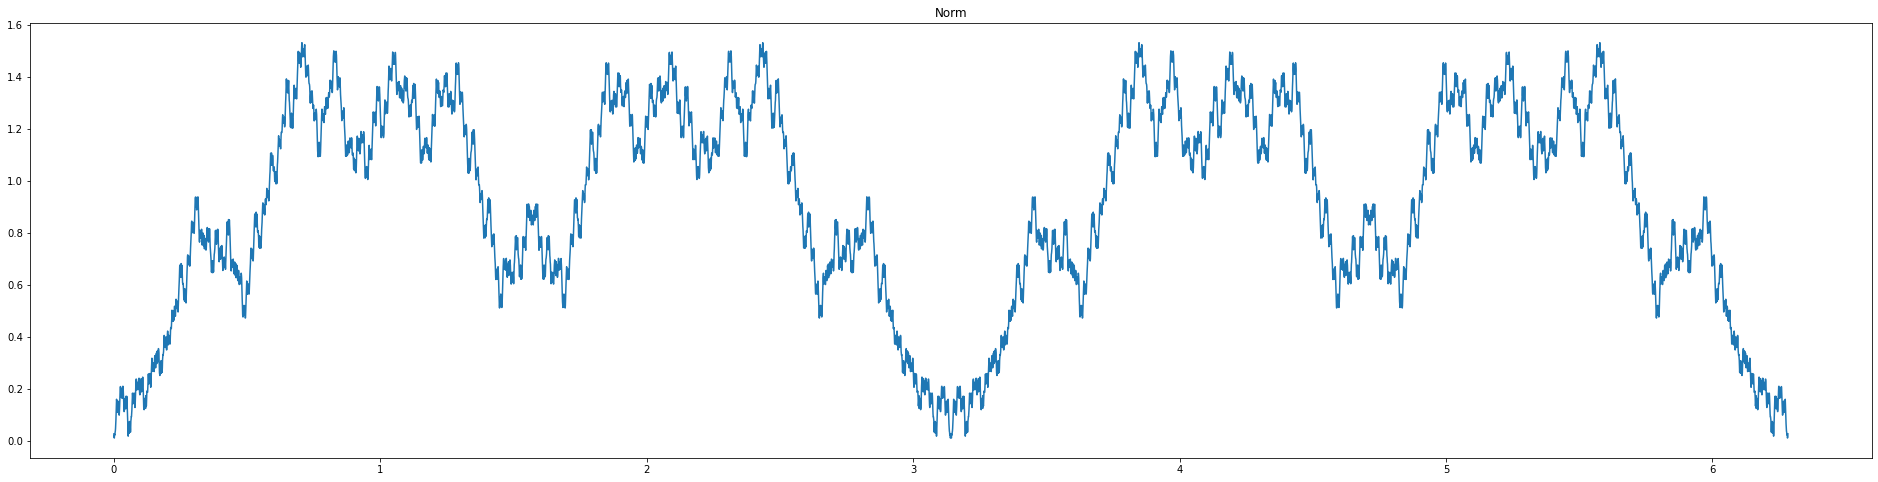

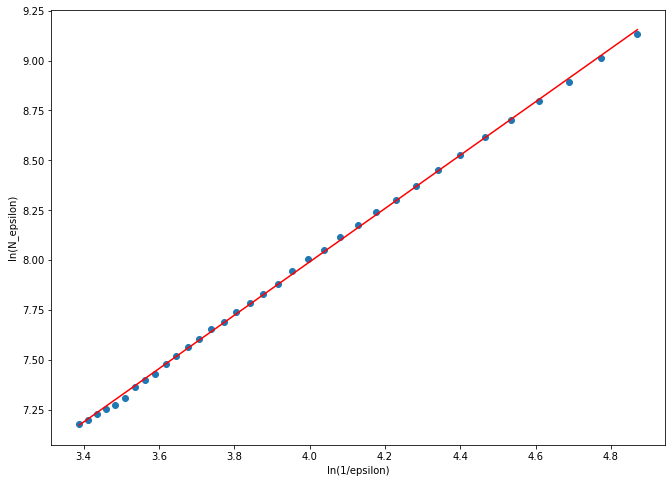

In [14]:
result = Solver(Data(e=0.1, p=2), eqn=1)
sol = result.solution()
result.print_graph()
box_dim = result.calc_box_dim(True)

We found that the box dimension for the Schrodinger equation with varying values $p$ likely never exceeds $1.4$. Although this number was exceeded for large $p$ in our approximations, increasing the time resolution increased the $p$ at which this occurred, and so we suspect that this is due to error. However, we can still definitively say that the box dimension of the Schrodinger equation subject to our initial conditions never exceeds $1.4$ for $p < 15$.


### Korteweg-deVries (KdV)

The following are the norms of the solutions to the KdV equations (with the dispersion relation $w(k) = −k^3 + k$) with $p = 2$ at times $e = 0.3, e = 0.31, e = 0.314$, and $e = 0.1π$, respectively:


boxDimension = 1.1703188726610425


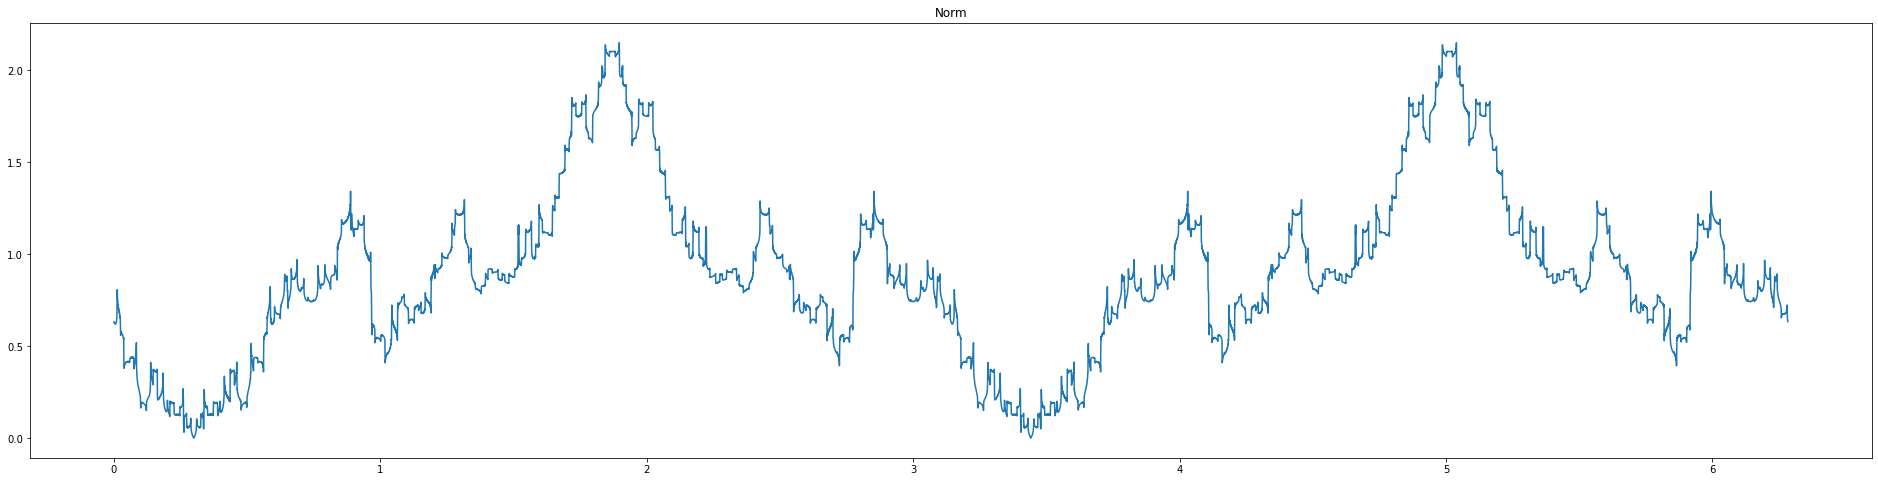

In [18]:
get_result(e=0.3, p=2, eqn=2)

boxDimension = 1.3352070979706534


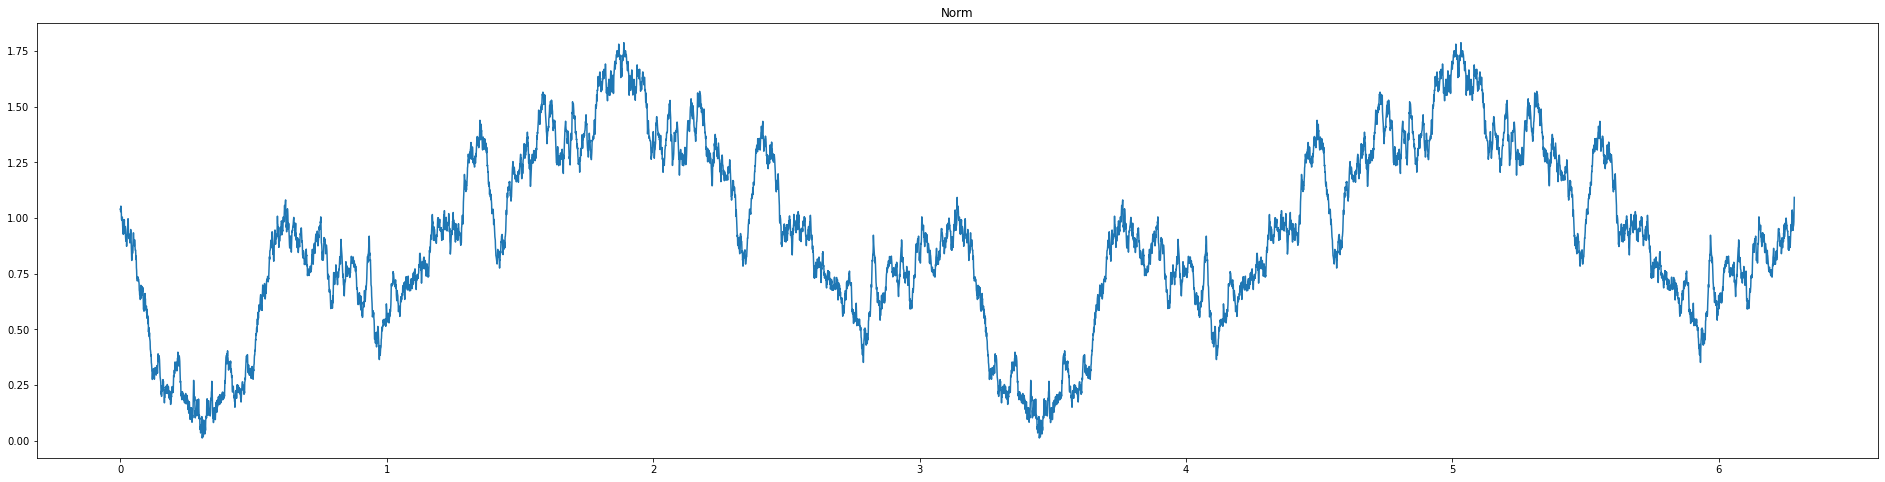

In [19]:
get_result(e=0.31, p=2, eqn=2)

boxDimension = 1.3293300152551022


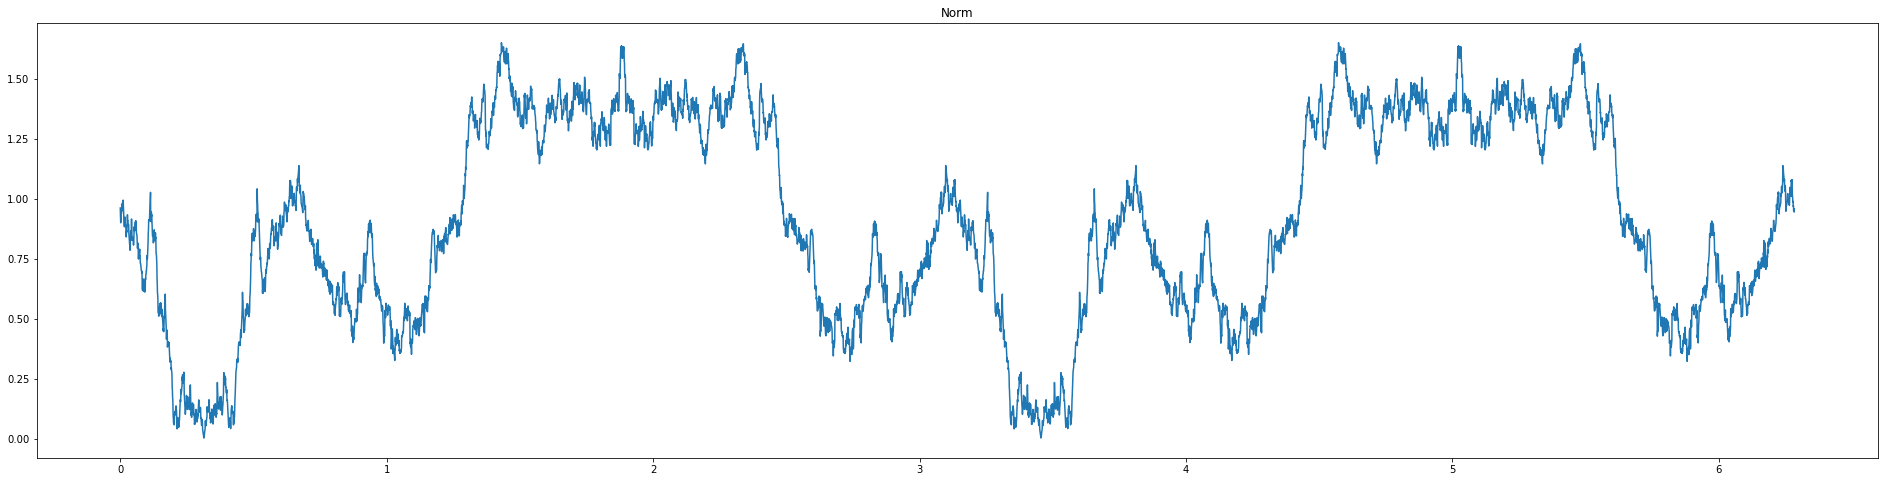

In [20]:
get_result(e=0.314, p=2, eqn=2)

boxDimension = 1.0237974592717005


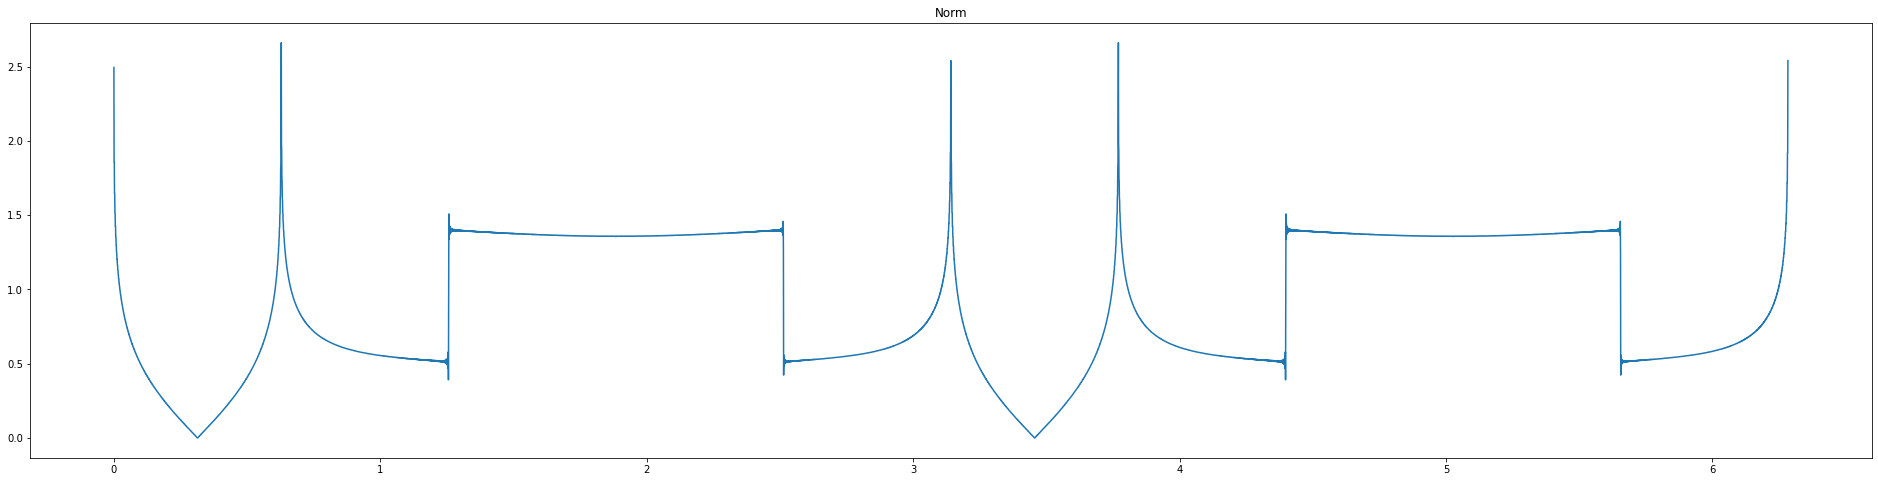

In [21]:
get_result(e=0.1*pi, p=2, eqn=2)

## Future Directions

Use the above methods to find solution profiles to other dispersive PDEs, and their associated box dimensions.

## References

[1] Gong Chen and Peter J. Olver. (2014). *Numerical Simulation of Nonlinear Dispersive Quantization*.

[2] M. Berry, I. Marzoli. and F. Schleich. (2001). *Quantum Carpets, carpets of Light Physics World*.

[3] H. Holden, K. H. Karlsen, N. H. Risebro, and T. Tao. (2009). *Operator Splitting for the KdV equation*.